# Kaggle - Titanic Tutorial_Part 2
**<분석 목적>**
- 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 **생존 여부**를 **예측**하는 모델을 생성하는 것이다.

**<튜토리얼 과정>**
1. 데이터 셋 확인
    - Null 값 존재 여부를 확인하고, Null 값들에 대한 처리를 해준다.
2. 탐색적 데이터 분석(EDA)
    - 여러 개의 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인한다.
    - 또한 시각화 라이브러리들을 활용하여 insight를 도출한다.
3. Feature Engineering(특성 공학)
    - 모델 설정에 앞서, 모델의 성능을 높이기 위한 작업이다.
    - 원-핫-인코딩(One-hot-encoding), class 나누기, 구간 나누기, 텍스트 데이터 처리 등...
4. 모델 생성
    - 사이킷런을 사용해서 모델을 만든다.
5. 모델 학습 및 예측
    - 학습 데이터 셋(train dataset)을 가지고 모델을 학습시킨 후, 테스트 데이터 셋(test dataset)을 가지고 예측을 수행한다.
6. 모델 평가
    - 모델의 예측 성능을 평가한다.
    - 우리가 직면한 문제에 맞게 모델 평가 지표를 결정하면 된다.
        - ex) RMSE, R_square, F1-score, ...

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 이 두 줄의 코드는 matplotlib의 기본 scheme말고, seaborn scheme을 세팅해준다
# 일일이 graph의 font size를 지정할 필요 없이, seaborn의 font_scale을 사용하면 편리하다
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

**본격적으로 <Part 2>를 시작하기에 앞서, <Part 1>에서 수행해주었던 작업들을 다시 수행해주겠다.**

In [2]:
df_train = pd.read_csv('../titanic/train.csv')
df_test = pd.read_csv('../titanic/test.csv')

# SibSp, Parch 변수를 하나의 변수(FamilySize)로 합쳐준다
# 자신을 포함해야하므로, 1 을 더해준다
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

# Fare 변수의 결측치들을 평균값으로 대체
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

# Fare 변수에 대해서 '로그 변환' 수행
df_train['Fare'] = df_train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

## Feature Engineering(특성 공학)

### Null 값 처리

**1. Age 변수의 Null 값 처리**
- Age에는 Null 값이 177개나 존재한다.
- 이를 채워주기 위해, **title + statistics** 를 사용해보겠다.
    - 영어에서는 Mr, Mrs, Miss와 같은 title이 존재한다.
    - 때문에 각 탑승객의 이름에는 위와 같은 title이 들어가게 되는데, 이를 사용해보겠다.

In [3]:
# 정규표현식을 사용하여 title을 추출
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [4]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap = 'summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [5]:
# 위에서 생성된 테이블을 참고하여 남자, 여자가 쓰는 Initial을 구분
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major',
                             'Lady', 'Countess', 'Jonkheer', 'Col',
                             'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                            ['Miss', 'Miss', 'Miss', 'Mr', 'Mr',
                             'Mrs', 'Mrs', 'Other', 'Other',
                             'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)

df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major',
                            'Lady', 'Countess', 'Jonkheer', 'Col',
                            'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr',
                            'Mrs', 'Mrs', 'Other', 'Other',
                            'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace = True)

In [6]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


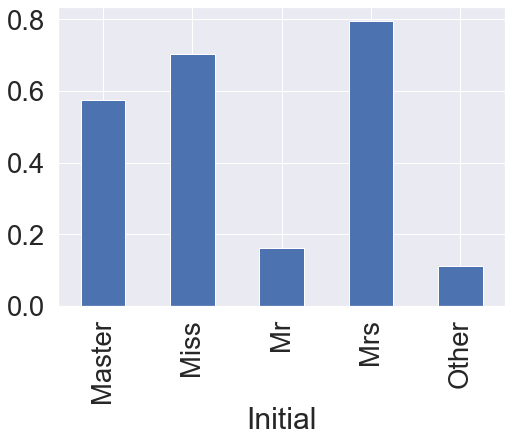

In [7]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 결과를 살펴보면, 여성과 관계있는 **Miss, Mrs**가 **생존률이 높은 것**을 알 수 있다.

**Statistics를 사용하여 Null 값 처리**
- 학습 데이터 셋에서 얻은 statistics를 기반으로, 테스트 데이터 셋의 Null 값을 채워줘야 한다.
- Pandas 데이터 프레임을 다룰 때에는 boolean array를 이용해서 indexing하는 방법이 정말 편리하다!!
    - ***```loc + boolean + column```*** 을 사용해서 값을 치환하는 방법은 자주 쓰이므로, 반드시 잘 숙지하도록 하자!!

In [8]:
# Age 변수에 존재하는 Null 값들을 Age 변수의 평균값으로 대체하기 위해, 평균값들을 확인
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [9]:
# Null 값들을 Age 변수의 평균값으로 대체
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull()) & (df_train.Initial == 'Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull()) & (df_test.Initial == 'Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial == 'Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial == 'Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial == 'Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull()) & (df_test.Initial == 'Other'), 'Age'] = 46

**2. Embarked 변수의 Null 값 처리**
- Embarked 변수에는 Null 값이 2개 존재한다.
- 탑승 항구 "S"에서 가장 많은 탑승객이 있었으므로, 간단하게 **Null 값들을 "S"로 대체**해주겠다.

In [10]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


In [11]:
df_train['Embarked'].fillna('S', inplace = True)

### 연속형 변수인 Age를 범주형 변수로 변환
- 이처럼 연속형 변수를 범주형 변수로 변환하는 경우, **정보 손실**이 **발생**할 수 있다.
- 그러나 본 튜토리얼에서는 다양한 방법들을 소개하는 것이 목적이므로 진행하도록 하겠다.
- 범주형 변수로 변환해주는 방법은 여러 가지가 존재한다.
    - 첫 번째 방법: 데이터 프레임의 indexing 방법인 ***```loc```*** 를 사용하여 직접 변환하는 방법
    - 두 번째 방법: ***```apply```*** 를 사용해서 함수를 넣어주는 방법
    - 참고로 두 번째 방법(***```apply```***)을 사용하는 것이 훨씬 더 간단하다!! 

In [12]:
# 1. loc 를 사용한 방법
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[df_train['Age'] >= 70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[df_test['Age'] >= 70, 'Age_cat'] = 7

In [13]:
# 2. apply 를 사용한 방법 --> 훨씬 더 간단!!
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat2'] = df_train['Age'].apply(category_age)
df_test['Age_cat2'] = df_test['Age'].apply(category_age)

In [14]:
# 첫 번째 방법(loc)과 두 번째 방법(apply)의 결과가 동일한지 확인
print('1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 를 반환해줘야 함 -> ',
      (df_train['Age_cat'] == df_train['Age_cat2']).all())

1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 를 반환해줘야 함 ->  True


In [15]:
# 이제 중복되는 Age_cat2 컬럼과 원래 컬럼인 Age를 제거해주겠다
df_train.drop(['Age', 'Age_cat2'], axis = 1, inplace = True)
df_test.drop(['Age', 'Age_cat2'], axis = 1, inplace = True)

### 문자열 변수인 Initial, Embarked, Sex를 수치형 변수로 변환
- ```map()``` 메소드를 사용하면 간단하게 변환해 줄 수 있다.

**Initial 변수를 수치화**

In [16]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

**Embarked 변수를 수치화**

In [17]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [20]:
# any()를 사용하여, True가 단 하나라도 있으면 True를 반환
# 즉, Null 값이 한 개라도 존재하면 True를 반환
df_train['Embarked'].isnull().any()

False

**Sex 변수를 수치화**

In [21]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

**각 feature 간의 상관관계를 시각화**
- 피어슨 상관계수가 **1 에 가까우면 양의 상관관계**, **-1 에 가까우면 음의 상관관계**이다.
- **피어슨 상관계수가 0** 이라는 것은 상관관계가 없다는 의미가 아니라, **선형적인 상관관계가 없다는 의미**이다.
    - 즉, **비선형적 상관관계는 존재할 수 있다!**

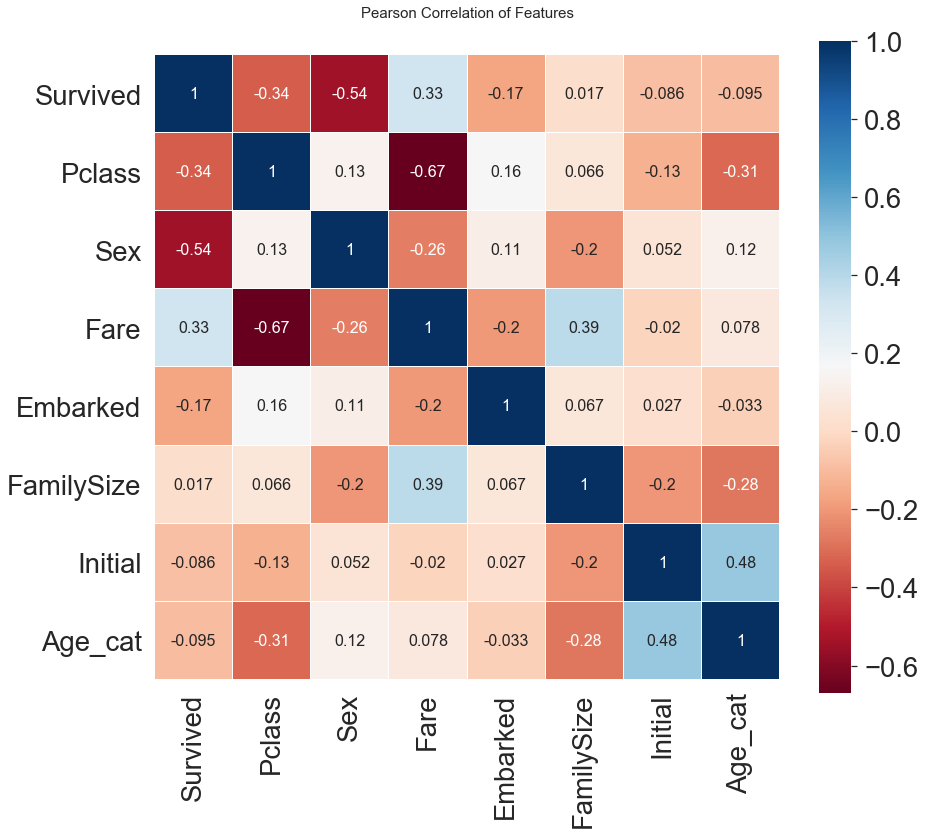

In [22]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 
                         'Fare', 'Embarked', 'FamilySize',
                         'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, 
            cmap = colormap, linecolor = 'white', annot = True, annot_kws = {'size': 16})

del heatmap_data

- 앞선 EDA 과정에서 살펴봤듯이, **Sex와 Pclass 변수가 Survived 변수와 어느 정도 상관관계가 존재함**을 알 수 있다.
- 하지만 **서로 강한 상관관계를 갖는 feature들은 존재하지 않는 것을 확인**할 수 있다.
    - 즉, **다중 공선성을 보이는 변수들이 존재하지 않는다**는 의미이다.
    - 다시 말해, 모델 생성에 있어서 **불필요한 feature가 없다**는 말이다.

### One-Hot Encoding(원-핫 인코딩)
- 수치화를 시켜준 범주형 데이터를 그대로 모델에 넣어줘도 되지만, 모델의 성능을 높여주기 위해서 **one-hot encoding** 작업을 수행해주겠다.
    - 원-핫 인코딩이라는게 쉽게 말하면 **가변수(더미변수)를 만들어주겠다**는 말이랑 동일하다.
    - **Pandas**의 ```get_dummies()```를 사용하면 쉽게 수행해 줄 수 있다.
        - ```prefix``` 옵션을 사용하면, **가변수에 공통으로 접두사를 추가**할 수 있다.
        - ```drop_first = True``` 옵션을 설정하면, **가변수의 첫 번째 변수를 자동으로 삭제**해준다.
            - 즉, **가변수 함정(dummy_trap)을 피할 수 있게 해준다 --> 총 (k-1)개의 가변수 생성!!**

**Initial 변수에 대해서 One-Hot Encoding 처리**

In [23]:
df_train = pd.get_dummies(df_train, columns = ['Initial'], prefix = 'Initial')
df_test = pd.get_dummies(df_test, columns = ['Initial'], prefix = 'Initial')

In [24]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


**Embarked 변수에 대해서 One-Hot Encoding 처리**

In [25]:
df_train = pd.get_dummies(df_train, columns = ['Embarked'], prefix = 'Embarked')
df_test = pd.get_dummies(df_test, columns = ['Embarked'], prefix = 'Embarked')

In [26]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,1,3,0,0,1,0,0,0,0,1


- 이제 **pandas**의 ```get_dummies()```를 사용하여 손쉽게 **One-Hot Encoding**을 수행해주었다.
- 추가적으로 **```Labelencoder``` + ```OneHotencoder```**를 이용해도 One-Hot Encoding이 가능하다.
- 그러나 본 튜토리얼에서는 그냥 **pandas**의 ```get_dummies()```를 사용하겠다.

### 불필요한 컬럼 제거

In [27]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [28]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [29]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 머신러닝 모델 생성 및 예측
- 본 튜토리얼은 **0 과 1 로 이루어진 target 변수에 대한 예측**을 수행하는 모델을 만드는 것이다.
    - 즉, **이진 분류 문제**라고 할 수 있다.
- 우선 **학습 데이터 셋**에서 **Survived를 제외한 input**을 가지고, **모델 최적화**를 수행해 줄 것이다.
- 그 후에 모델이 학습하지 않았던 **테스트 데이터 셋을 input**으로 주어서, **테스트 데이터 셋의 각 탑승객의 생존 여부를 예측**해보겠다.
- 본 튜토리얼에서는 **랜덤 포레스트** 모델을 사용할 것이다.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

### 데이터 셋 분할
1. **모델 학습**에 사용할 ***train dataset***
2. **모델 평가**에 사용할 ***valid dataset***
    - 좋은 모델을 만들기 위해서는 ***valid dataset*** 을 따로 만들어서 모델을 평가해주어야 한다.
    - 마치 축구대표팀이 **팀훈련(train)**을 하고 바로 **월드컵(test)**에 나가는 것이 아니라, **팀훈련(train)**을 한 다음 **평가전(valid)**을 거쳐 **팀의 훈련 정도(학습 정도)를 확인**하고 **월드컵(test)**에 나가는 것과 비슷하다.
3. **모델 예측**에 사용할 ***test dataset***

- 먼저 **학습 데이터 셋(train dataset)**과 **target label(Survived)**을 **분리**하겠다.

In [31]:
X_train = df_train.drop('Survived', axis = 1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- ```train_test_split()```을 사용하여 데이터 셋을 쉽게 분할할 수 있다.

In [32]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.3, random_state = 2020)

### 모델 학습 및 예측
- 먼저 모델 객체를 만들고, ```fit()``` 메소드로 학습시키겠다.
- 그 다음, **valid dataset**을 input으로 넣어줘서 예측 값을 구해보도록 하겠다.

In [33]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

print('총 {}명 중, {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중, 81.34% 정확도로 생존을 맞춤


- 파라미터 튜닝을 하지도 않았는데 **약 82 %의 정확도**가 나왔다!!

## Feature 중요도 확인
- 생성된 예측 모델이 어떤 feature의 영향을 많이 받았는지 확인해보는 작업을 수행하겠다.

In [34]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index = df_test.columns)

In [35]:
df_test.columns

Index(['Pclass', 'Sex', 'Fare', 'FamilySize', 'Age_cat', 'Initial_0',
       'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

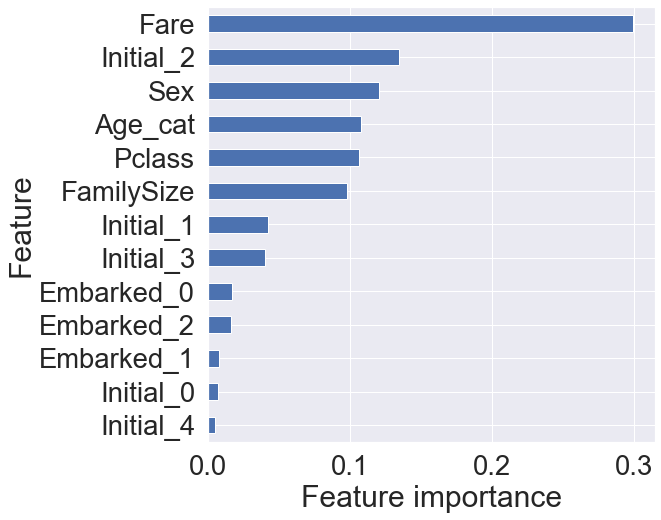

In [36]:
plt.figure(figsize = (8, 8))
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 결과를 보면, 가장 중요도가 높은 feature는 **Fare**이다.
- 그 다음으로 **Sex, Initial_2, Age_cat**이 뒤를 이었다.
- 만약 좀 더 정확도가 높은 모델을 얻고 싶다면, **feature selection**을 수행해주면 된다.

## 테스트 데이터 셋에 대해서 예측을 수행
- 이제 모델이 학습하지 않았던 테스트 데이터 셋을 input으로 넣어주고, 각 탑승객의 생존 여부를 예측해보겠다.
- Kaggle에서 준 파일인 **gender_submission.csv** 파일을 읽어와서 제출할 준비를 하겠다.

In [37]:
submission = pd.read_csv('../titanic/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [38]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [39]:
submission.to_csv('./my_first_submission.csv', index = False)

**여기까지 해서 타이타닉 튜토리얼을 마무리하도록 하겠다!**

**비록 본 튜토리얼에서는 기본적인 데이터 전처리 과정과 단순한 모델을 사용해서 예측 모델을 만들었지만, 앞으로 공부를 이어나가면서 더욱 참신한 아이디어로 머신러닝 모델을 만들어 볼 예정이다.**